# Projet 4

In [ ]:
import sys # Python v3.12.4
import pandas as pd # v2.2.2
import numpy as np # v2.1.1
import matplotlib.pyplot as plt
import seaborn as sns # v0.13.2
import missingno as msno # 0.5.2
import sklearn as sk # 1.5.2
import shap
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#!pip install shap

In [ ]:
# Information sur l'environnement virtuel
print("Version des librairies :")
print("Python        : " + sys.version)
print("Pandas        : " + pd.__version__)
print("NumPy         : " + np.version.__version__)
print("Seaborn       : " + sns.__version__)
print("missingno     : " + msno.__version__)
print("sklearn       : " + sk.__version__)

Version des librairies :
Python        : 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas        : 2.2.2
NumPy         : 1.26.4
Seaborn       : 0.13.2
missingno     : 0.5.2
sklearn       : 1.5.2


In [ ]:
def matrice_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances=None):
    # Création de la figure
    fig = plt.figure(figsize=(20,15))

    # Matrice de confusion
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Labels pour l'annotation de la matrice
    group_names = ["Vrai Négatif", "Faux Positif", "Faux Négatif", "Vrai Positif"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Affichage de la matrice de confusion sous forme de heatmap
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues", cbar=False)
    plt.title("Matrice de Confusion")
    plt.xlabel("Classe Prédite")
    plt.ylabel("Classe Réelle")

    # Courbe ROC et AUC
    plt.subplot(222)

    # Calcul de la courbe ROC et de l'AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Tracé de la courbe ROC
    plt.plot(fpr, tpr, color="orange", linewidth=5, label="AUC = %0.4f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--", label="Classification aléatoire")
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("Courbe ROC")
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_models(model, X_train_sm, X_test, y_train_sm, y_test):
    model.fit(X_train_sm, y_train_sm)  # Entraînement du modèle

    # Prédiction des probabilités et des classes
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    output = {
        "AUC": roc_auc_score(y_test, y_pred_proba),  # AUC
        "Accuracy": accuracy_score(y_test, y_pred),  # Accuracy
        "Precision": precision_score(y_test, y_pred),  # Precision
        "Recall": recall_score(y_test, y_pred),  # Recall
        "F1": f1_score(y_test, y_pred)  # F1 Score
    }

    return output

def cost_false(model, y_true, X_true):
    '''La fonction de coût analyse les erreurs de prédiction FP and FN.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)

    print("Faux Positifs: {0:.2%}".format(FP))
    print("Faux Négatifs: {0:.2%}".format(FN))

    return FP, FN

def calculate_total_cost(y_true, y_pred_proba, threshold):
    # Convertir les probabilités en prédictions binaires en utilisant le seuil
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculer le coût total
    total_cost = (fp * 1) + (fn * 10)

    return total_cost

## Importation des données

In [ ]:
new_var = pd.read_csv("P4_new_var.csv")
X_train_sm = pd.read_csv("X_train_sm.csv")
y_train_sm = pd.read_csv("y_train_sm.csv")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [ ]:
new_var.head()

,TARGET,PREV_DESK_MEAN_DAYS_CREDIT,DAYS_BIRTH,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_INCOME_TYPE_Working,PREV_DESK_MEAN_DAYS_CREDIT_UPDATE,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,...,OCCUPATION_TYPE_Laborers,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,NAME_EDUCATION_TYPE_Higher education,DAYS_EMPLOYED,EMERGENCYSTATE_MODE_No,CODE_GENDER_F,HOUSETYPE_MODE_block of flats,NAME_INCOME_TYPE_Pensioner
0,1,-874.000000,-9461,1.0,1.0,-499.875000,2,2,-1134.0,1,...,1.0,0.262949,0.139376,0.083037,0.0,-637.0,1.0,0.0,1.0,0.0
1,0,-1400.750000,-16765,0.0,0.0,-816.000000,1,1,-828.0,1,...,0.0,0.622246,0.535276,0.311267,1.0,-1188.0,1.0,1.0,1.0,0.0
2,0,-867.000000,-19046,1.0,1.0,-532.000000,2,2,-815.0,0,...,1.0,0.555912,0.729567,0.505998,0.0,-225.0,0.0,0.0,0.0,0.0
3,0,-1050.571429,-19005,1.0,1.0,-481.833333,2,2,-617.0,1,...,1.0,0.650442,0.535276,0.505998,0.0,-3039.0,0.0,1.0,0.0,0.0
4,0,-1149.000000,-19932,1.0,1.0,-783.000000,2,2,-1106.0,0,...,0.0,0.322738,0.535276,0.505998,0.0,-3038.0,0.0,0.0,0.0,0.0


In [ ]:
new_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 25 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   TARGET                                             307507 non-null  int64  
 1   PREV_DESK_MEAN_DAYS_CREDIT                         307507 non-null  float64
 2   DAYS_BIRTH                                         307507 non-null  int64  
 3   NAME_EDUCATION_TYPE_Secondary / secondary special  307507 non-null  float64
 4   NAME_INCOME_TYPE_Working                           307507 non-null  float64
 5   PREV_DESK_MEAN_DAYS_CREDIT_UPDATE                  307507 non-null  float64
 6   REGION_RATING_CLIENT_W_CITY                        307507 non-null  int64  
 7   REGION_RATING_CLIENT                               307507 non-null  int64  
 8   DAYS_LAST_PHONE_CHANGE                             307507 non-null  float6

In [ ]:
nb_lignes, nb_colonnes = new_var.shape
type_colonnes = new_var.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 307507
Nombre de colonnes : 25
Type des colonnes : 
float64    19
int64       6
Name: count, dtype: int64


# Entrainement du jeu de données

In [ ]:
# Initialisation du DummyClassifier avec la stratégie "most_frequent"
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_sm, y_train_sm)

# Prédiction des étiquettes de classe
y_dummy_pred = dummy_clf.predict(X_test)

# Prédiction des probabilités de la classe positive
y_dummy_pred_proba = dummy_clf.predict_proba(X_test)[:, 1]

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_dummy_pred)
print("Accuracy du DummyClassifier:", accuracy)

# Calcul de l'AUC
auc = roc_auc_score(y_test, y_dummy_pred_proba)
print("AUC du DummyClassifier:", auc)

Accuracy du DummyClassifier: 0.5051868231927417
AUC du DummyClassifier: 0.5005611525402511


## Regression Logistique

In [ ]:
# Définition de l'hyperparamètre à tester pour C
param_grid = {"C": [0.01, 0.05, 0.1, 0.15, 1, 10]}

# Création d'un objet GridSearchCV avec régression logistique et validation croisée à 5 plis (cv=5)
grid_search = GridSearchCV(LogisticRegression(penalty="l2"), param_grid, cv=5, n_jobs=-1)

# Démarrage du chronomètre
debut = time.time()

# Entraînement du modèle sur les données d'entraînement
grid_search.fit(X_train_sm, y_train_sm)

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution:.4f} secondes")

# Affichage de la meilleure valeur du paramètre C trouvée par GridSearchCV
best_C = grid_search.best_params_["C"]
print(f"Meilleur paramètre C : {best_C}")

Temps d'exécution : 18.3830 secondes
Meilleur paramètre C : 0.01


In [ ]:
# Démarrage du chronomètre pour l'entraînement du modèle
debut_entrainement = time.time()

# Initialisation du modèle de régression logistique avec régularisation L2 et C=0.10
logreg = LogisticRegression(C=0.01, penalty="l2")

# Entraînement du modèle sur les données d'entraînement
logreg.fit(X_train_sm, y_train_sm)

# Arrêt du chronomètre pour l'entraînement du modèle
fin_entrainement = time.time()

# Temps d'exécution de l'entraînement
temps_execution_entrainement = fin_entrainement - debut_entrainement
print(f"Temps d'exécution pour l'entraînement : {temps_execution_entrainement:.4f} secondes")

# Démarrage du chronomètre pour le calcul des prédictions
debut_predictions = time.time()

# Calcul de l'AUC sur les données de test
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Arrêt du chronomètre pour le calcul des prédictions
fin_predictions = time.time()

# Temps d'exécution pour les prédictions et le calcul de l'AUC
temps_execution_predictions = fin_predictions - debut_predictions
print(f"Temps d'exécution pour les prédictions et l'AUC : {temps_execution_predictions:.4f} secondes")

# Affichage de l'AUC
print("AUC : %0.4f" % roc_auc)

# Affichage du rapport de classification (précision, rappel, F1-score)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

Temps d'exécution pour l'entraînement : 1.7580 secondes
Temps d'exécution pour les prédictions et l'AUC : 0.0200 secondes
AUC : 0.6770
              precision    recall  f1-score   support

           0       0.95      0.60      0.74     56537
           1       0.13      0.65      0.21      4965

    accuracy                           0.61     61502
   macro avg       0.54      0.63      0.48     61502
weighted avg       0.89      0.61      0.70     61502



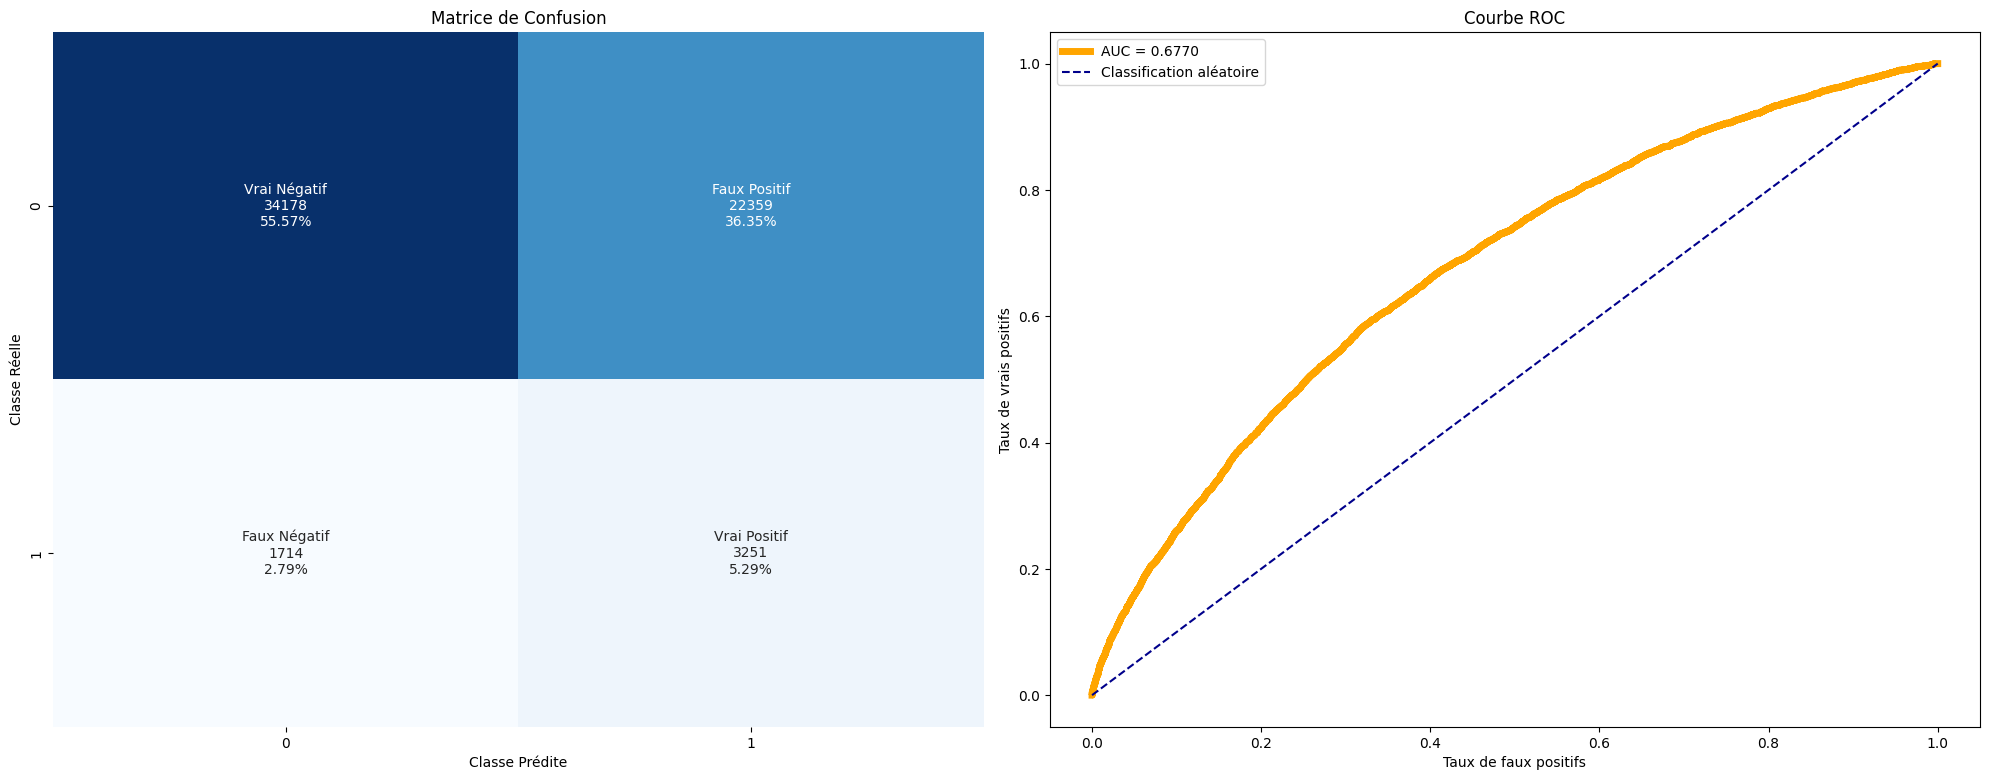

In [ ]:
matrice_roc_auc(logreg, y_test, logreg.predict(X_test), logreg.predict_proba(X_test)[:,1], feature_importances=None)

Détails

## Arbre de décision

In [ ]:
# Définition de la grille de recherche pour max_depth (profondeur maximale de l'arbre)
param_grid = [{"max_depth": list(range(1, 10))}]

# Création de l'objet GridSearchCV avec un arbre de décision et validation croisée à 5 plis
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)

# Démarrage du chronomètre
debut = time.time()

# Entraînement du modèle sur les données d'entraînement
grid_search_opt = grid_search.fit(X_train_sm, y_train_sm)

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution = fin - debut
print(f"Temps d'exécution : {temps_execution:.4f} secondes")

# Affichage du meilleur paramètre trouvé pour max_depth
print(f"Meilleur paramètre max_depth : {grid_search_opt.best_params_['max_depth']}")

Temps d'exécution : 11.4510 secondes
Meilleur paramètre max_depth : 9


In [ ]:
# Démarrage du chronomètre pour l'entraînement
debut_entrainement = time.time()

# Initialisation du modèle DecisionTreeClassifier avec une profondeur maximale de 9
dtree = DecisionTreeClassifier(max_depth=9)

# Entraînement du modèle sur les données d'entraînement
dtree.fit(X_train_sm, y_train_sm)

# Arrêt du chronomètre pour l'entraînement
fin_entrainement = time.time()

# Calcul du temps d'exécution de l'entraînement
temps_execution_entrainement = fin_entrainement - debut_entrainement
print(f"Temps d'exécution pour l'entraînement : {temps_execution_entrainement:.4f} secondes")

# Démarrage du chronomètre pour le calcul des prédictions et des métriques
debut_predictions = time.time()

# Calcul de l'AUC sur les données de test
y_pred_proba = dtree.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC : %0.4f" % roc_auc)

# Liste des prédicteurs utilisés (caractéristiques)
predictors = list(X_train_sm)

# Précision du modèle sur les données de test
test_accuracy = dtree.score(X_test, y_test)
print("Précision de l’arbre de décision sur l’ensemble de test: {:.3f}".format(test_accuracy))

# Prédiction des classes sur les données de test
y_pred = dtree.predict(X_test)

# Affichage du rapport de classification (précision, rappel, F1-score)
print(classification_report(y_test, y_pred))

# Arrêt du chronomètre pour les prédictions et les métriques
fin_predictions = time.time()

# Calcul du temps d'exécution pour les prédictions et les métriques
temps_execution_predictions = fin_predictions - debut_predictions
print(f"Temps d'exécution pour les prédictions et le calcul des métriques : {temps_execution_predictions:.4f} secondes")

Temps d'exécution pour l'entraînement : 3.8020 secondes
AUC : 0.6842
Précision de l’arbre de décision sur l’ensemble de test: 0.912
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     56537
           1       0.22      0.04      0.06      4965

    accuracy                           0.91     61502
   macro avg       0.57      0.51      0.51     61502
weighted avg       0.86      0.91      0.88     61502

Temps d'exécution pour les prédictions et le calcul des métriques : 0.0810 secondes


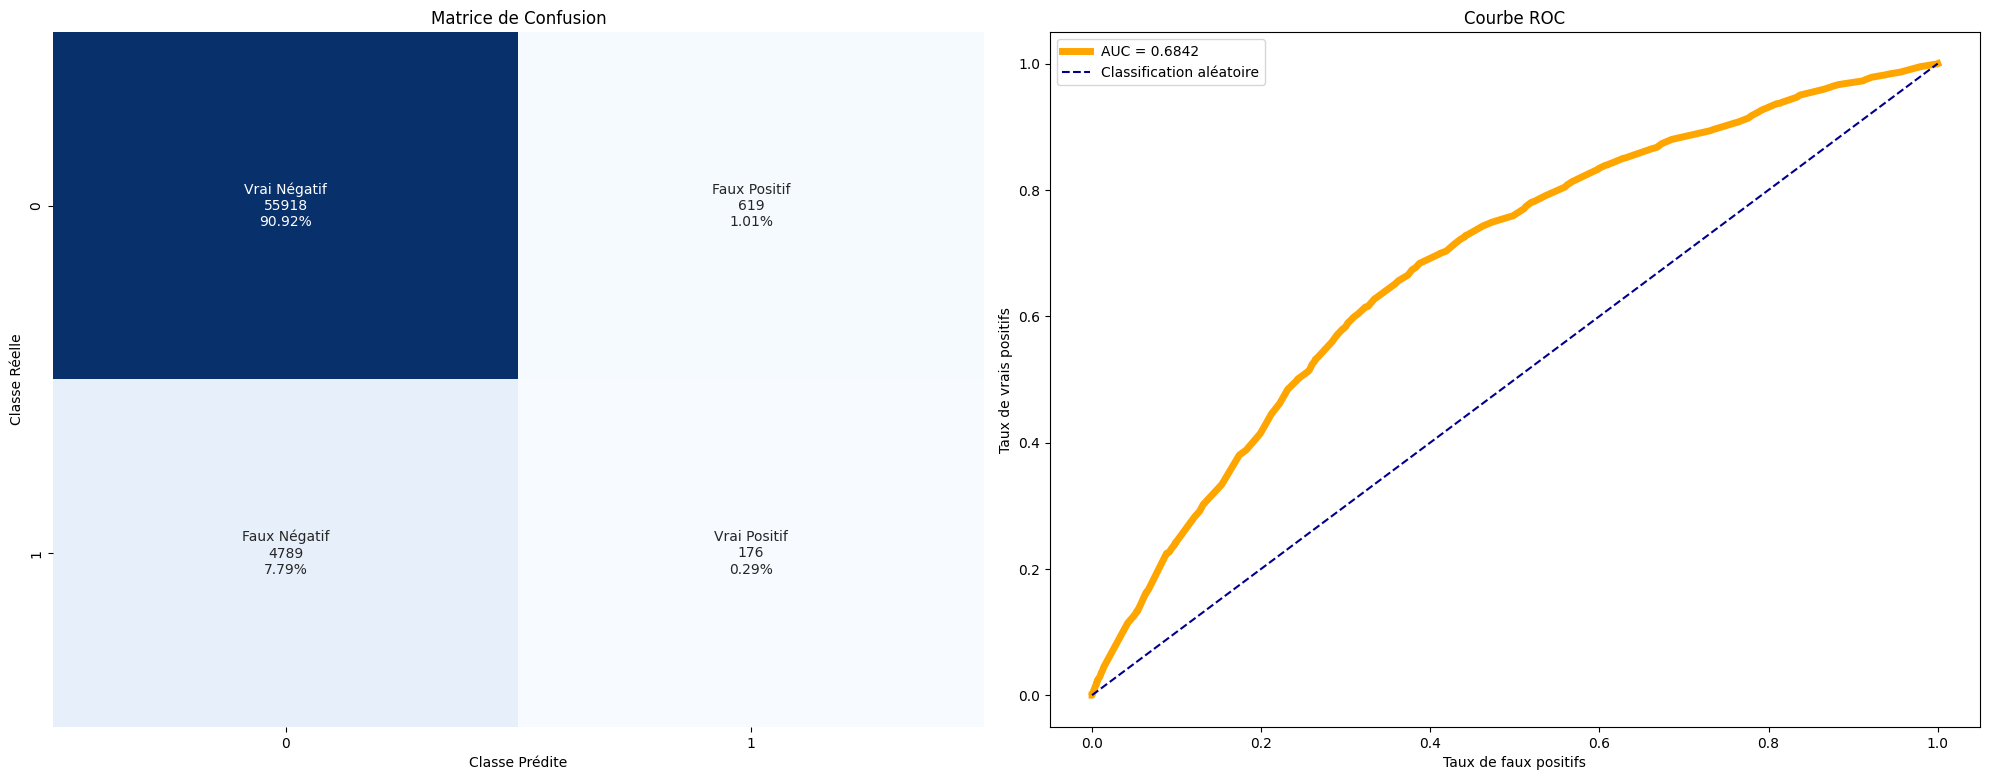

In [ ]:
matrice_roc_auc(dtree, y_test, dtree.predict(X_test), dtree.predict_proba(X_test)[:,1], feature_importances=None)

Details

In [ ]:
# Liste des modèles
models = [
    CatBoostClassifier(logging_level="Silent"),
    LGBMClassifier(verbose=-1),
    XGBClassifier()
]

# Initialisation des listes pour les métriques
name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
fp = []
training_time = []  # Liste pour stocker le temps d'entraînement

# Boucle sur chaque modèle
for model in models:
    # Démarrage du chronomètre
    debut = time.time()

    # Entraînement et évaluation du modèle
    results = train_models(model, X_train_sm, X_test, y_train_sm, y_test)

    # Arrêt du chronomètre
    fin = time.time()

    # Calcul du temps d'exécution
    temps_execution = fin - debut

    # Calcul des faux positifs
    cf = cost_false(model, y_test, X_test)

    # Ajout des résultats dans les listes
    name.append(type(model).__name__)
    auc.append(results["AUC"])
    accuracy.append(results["Accuracy"])
    precision.append(results["Precision"])
    recall.append(results["Recall"])
    f1.append(results["F1"])
    fp.append(cf[0])
    training_time.append(temps_execution)  # Ajout du temps d'entraînement

# Création du DataFrame avec les résultats
base_models = pd.DataFrame({
    "Model": name,
    "AUC": auc,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "FP": fp,
    "Training Time (seconds)": training_time  # Ajout du temps d'entraînement au DataFrame
})

# Trier les modèles par AUC
base_models.sort_values("AUC", ascending=False, inplace=True)

Faux Positifs: 1.12%
Faux Négatifs: 7.57%
Faux Positifs: 1.03%
Faux Négatifs: 7.61%
Faux Positifs: 1.38%
Faux Négatifs: 7.51%


In [ ]:
# Détails des modèls
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,FP,Training Time (seconds)
1,LGBMClassifier,0.720815,0.913515,0.307190,0.056798,0.095869,0.010341,0.916499
2,XGBClassifier,0.714716,0.911092,0.288833,0.069285,0.111761,0.013772,0.958999
0,CatBoostClassifier,0.712918,0.913109,0.310310,0.062437,0.103957,0.011203,18.513481


# CatBoost

In [ ]:
# Définition de la grille d'hyperparamètres à tester
param_grid = {
    "iterations": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "depth": [4, 6, 8]
}

# Initialisation du modèle CatBoost
model = CatBoostClassifier(logging_level="Silent")

# Démarrage du chronomètre
debut = time.time()

# GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train_sm, y_train_sm)

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution = fin - debut
print(f"Temps d'exécution pour la recherche des hyperparamètres : {temps_execution:.4f} secondes")

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour CatBoost:", grid_search.best_params_)
print("Meilleur score AUC:", grid_search.best_score_)

Temps d'exécution pour la recherche des hyperparamètres : 406.0631 secondes
Meilleurs hyperparamètres pour CatBoost: {'depth': 8, 'iterations': 300, 'learning_rate': 0.2}
Meilleur score AUC: 0.9640911891777749


# XGBClassifier

In [ ]:
# Grille d'hyperparamètres à tester
param_dist = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "colsample_bytree": [0.3, 0.5, 0.7],
    "subsample": [0.5, 0.7, 1.0]
}

# Initialisation du modèle XGBoost
xgb_model = XGBClassifier()

# Démarrage du chronomètre
debut = time.time()

# RandomizedSearchCV pour tester un échantillon aléatoire d'hyperparamètres
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring="roc_auc", n_jobs=-1)
random_search.fit(X_train_sm, y_train_sm)

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution = fin - debut
print(f"Temps d'exécution pour la recherche des hyperparamètres : {temps_execution:.4f} secondes")

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour XGBoost:", random_search.best_params_)
print("Meilleur score AUC:", random_search.best_score_)

Temps d'exécution pour la recherche des hyperparamètres : 33.7570 secondes
Meilleurs hyperparamètres pour XGBoost: {'subsample': 0.7, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Meilleur score AUC: 0.9614953968840062


# LGBMClassifier

In [ ]:
# Définition de la grille d'hyperparamètres à tester
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "num_leaves": [31, 50, 100],
    "boosting_type": ["gbdt", "dart"]
}

# Initialisation du modèle LightGBM
lgb_model = LGBMClassifier()

# Démarrage du chronomètre
debut = time.time()

# GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train_sm, y_train_sm)

# Arrêt du chronomètre
fin = time.time()

# Calcul du temps d'exécution
temps_execution = fin - debut
print(f"Temps d'exécution pour la recherche des hyperparamètres : {temps_execution:.4f} secondes")

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres pour LightGBM:", grid_search.best_params_)
print("Meilleur score AUC:", grid_search.best_score_)

Temps d'exécution pour la recherche des hyperparamètres : 467.0145 secondes
Meilleurs hyperparamètres pour LightGBM: {'boosting_type': 'gbdt', 'learning_rate': 0.2, 'n_estimators': 200, 'num_leaves': 100}
Meilleur score AUC: 0.9664713585069924


# Modèle retenue

AUC : 0.715044
Temps d'exécution pour le calcul de l'AUC : 0.0555 secondes
Précision du GBM sur l’ensemble de test: 0.912
Temps d'exécution pour le calcul de la précision : 0.0400 secondes
Temps d'exécution pour les prédictions : 0.0365 secondes
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     56537
           1       0.30      0.07      0.11      4965

    accuracy                           0.91     61502
   macro avg       0.61      0.53      0.53     61502
weighted avg       0.87      0.91      0.89     61502

Temps d'exécution pour le rapport de classification : 0.0480 secondes


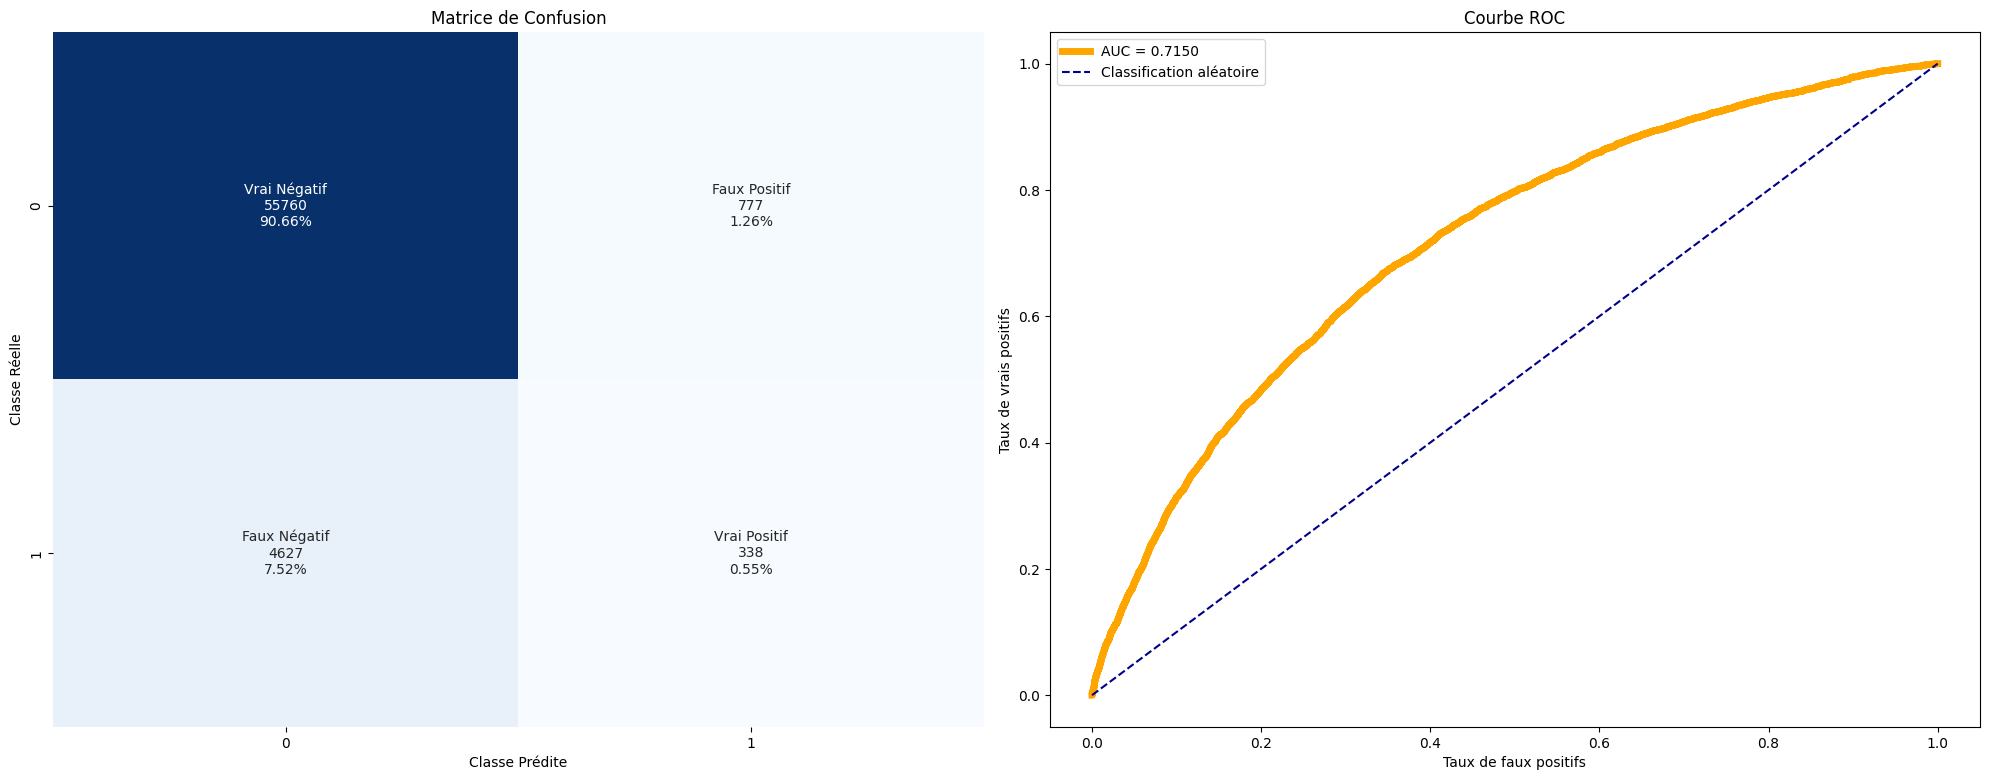

Temps d'exécution pour la matrice de confusion et la courbe ROC : 0.2295 secondes
Temps d'exécution total : 0.4100 secondes


In [ ]:
# Démarrage du chronomètre pour l'utilisation du meilleur modèle
debut_total = time.time()

# Utilisation du meilleur modèle GridSearchCV
best_lgbm_model = grid_search.best_estimator_

# Démarrage du chronomètre pour le calcul de l'AUC
debut_auc = time.time()

# Calcul de l'AUC
roc_auc = roc_auc_score(y_test, best_lgbm_model.predict_proba(X_test)[:, 1])
fin_auc = time.time()

print("AUC : %0.6f" % roc_auc)
print(f"Temps d'exécution pour le calcul de l'AUC : {fin_auc - debut_auc:.4f} secondes")

predictors = list(X_train_sm)

# Démarrage du chronomètre pour le calcul de la précision
debut_precision = time.time()

# Calcul de la précision sur le jeu de test
test_accuracy = best_lgbm_model.score(X_test, y_test)
fin_precision = time.time()

print("Précision du GBM sur l’ensemble de test: {:.3f}".format(test_accuracy))
print(f"Temps d'exécution pour le calcul de la précision : {fin_precision - debut_precision:.4f} secondes")

# Démarrage du chronomètre pour les prédictions
debut_predictions = time.time()

# Prédictions
pred = best_lgbm_model.predict(X_test)
fin_predictions = time.time()

print(f"Temps d'exécution pour les prédictions : {fin_predictions - debut_predictions:.4f} secondes")

# Démarrage du chronomètre pour le rapport de classification
debut_classification = time.time()

# Rapport de classification
print(classification_report(y_test, pred))
fin_classification = time.time()

print(f"Temps d'exécution pour le rapport de classification : {fin_classification - debut_classification:.4f} secondes")

# Démarrage du chronomètre pour la matrice de confusion et la courbe ROC
debut_matrice_roc = time.time()

# Affichage de la matrice de confusion et de la courbe ROC
matrice_roc_auc(best_lgbm_model, y_test, pred, best_lgbm_model.predict_proba(X_test)[:, 1], feature_importances=None)
fin_matrice_roc = time.time()

print(f"Temps d'exécution pour la matrice de confusion et la courbe ROC : {fin_matrice_roc - debut_matrice_roc:.4f} secondes")

# Calcul du temps total
fin_total = time.time()
print(f"Temps d'exécution total : {fin_total - debut_total:.4f} secondes")



# Cout métier FP vs FN

In [ ]:
thresholds = np.linspace(0, 1, 100)
costs = []

for threshold in thresholds:
    cost = calculate_total_cost(y_test, y_pred_proba, threshold)
    costs.append(cost)

# Trouver le seuil avec le coût minimum
optimal_threshold = thresholds[np.argmin(costs)]
print(f"Seuil optimal : {optimal_threshold:.2f}")

Seuil optimal : 0.17


In [ ]:
model = best_lgbm_model
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcul du coût total pour le modèle
total_cost = calculate_total_cost(y_test, y_pred_proba, optimal_threshold)
print(f"Coût total pour le modèle : {total_cost}")

Coût total pour le modèle : 37465


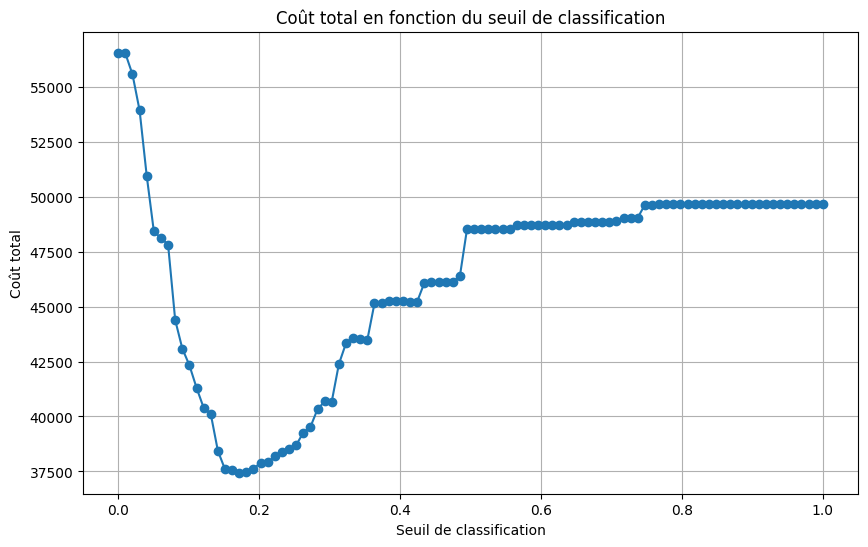

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, marker='o')
plt.xlabel('Seuil de classification')
plt.ylabel('Coût total')
plt.title('Coût total en fonction du seuil de classification')
plt.grid(True)
plt.show()

# Feature importance

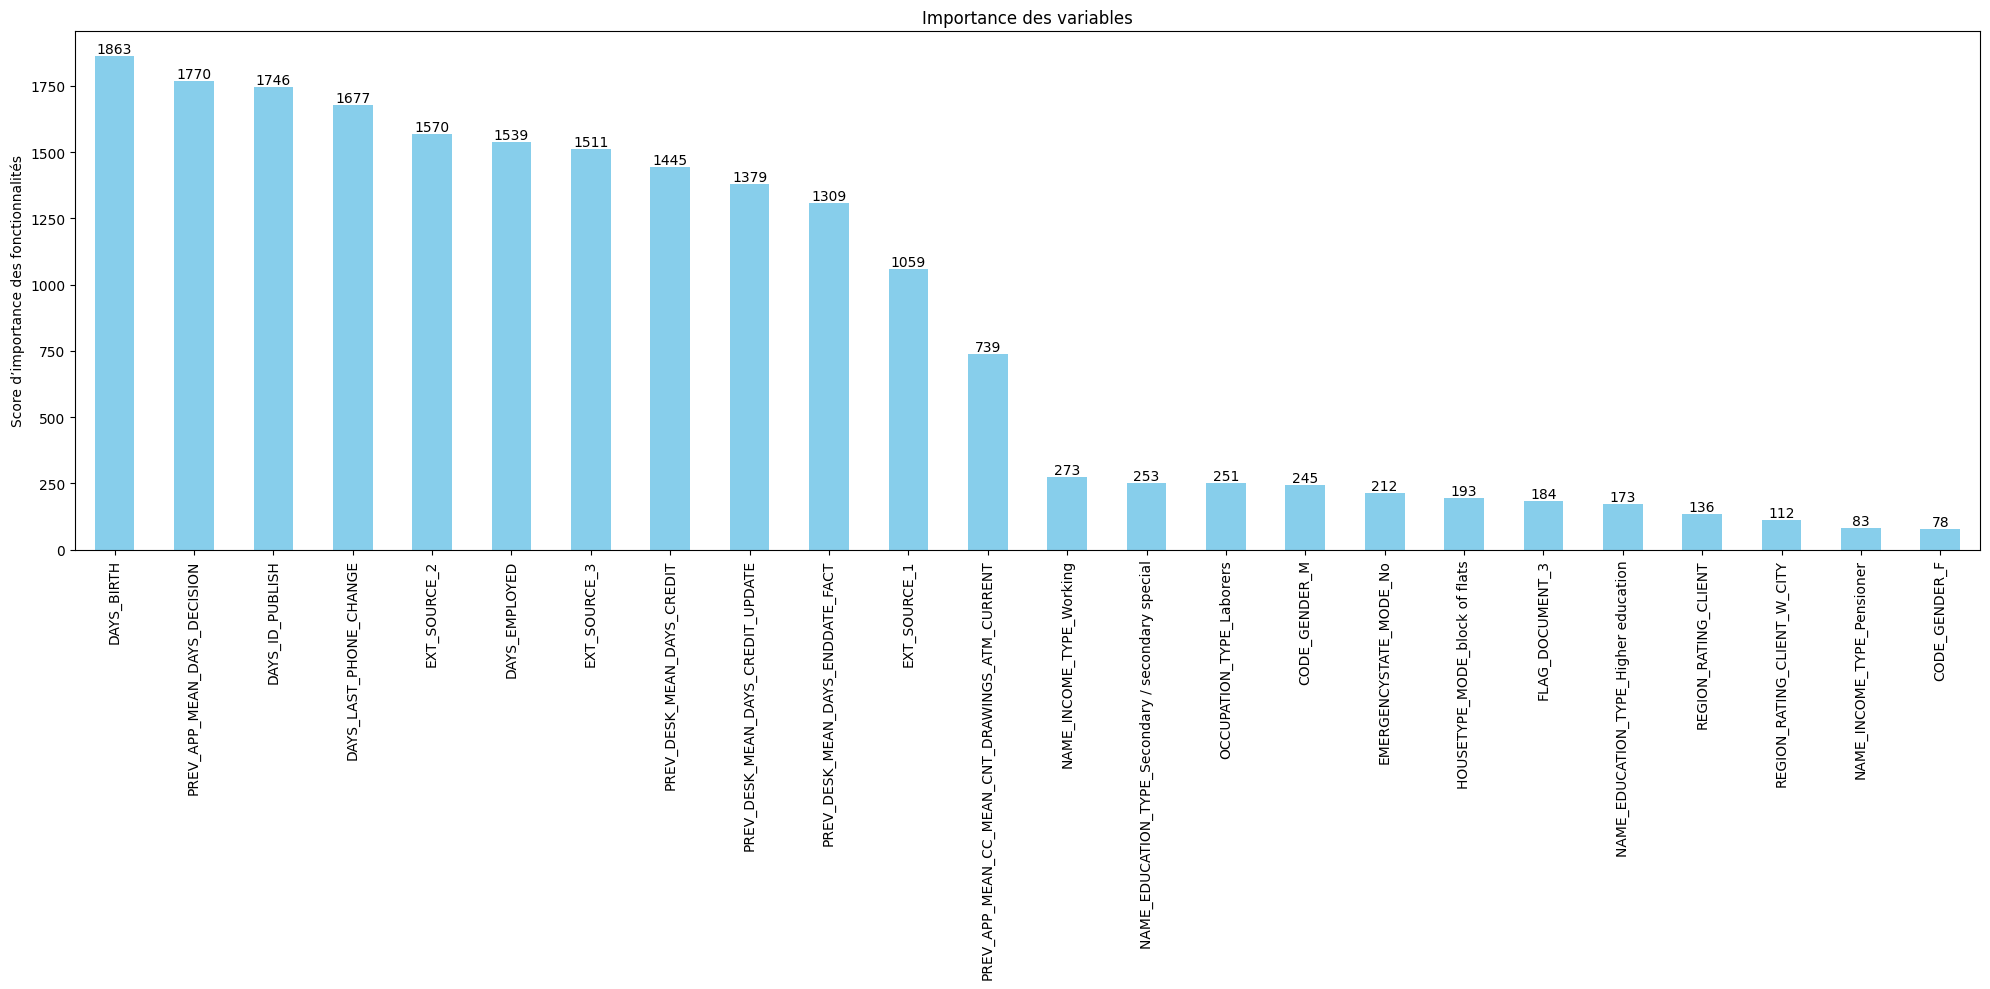

In [ ]:
# Calcul et tri des importances des caractéristiques
feat_imp = pd.Series(best_lgbm_model.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(20, 10))
ax = feat_imp.plot(kind="bar", color="skyblue", title="Importance des variables")

for i in ax.containers:
    ax.bar_label(i, label_type="edge", fontsize=10)

plt.ylabel("Score d’importance des fonctionnalités")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Shap en vue globale

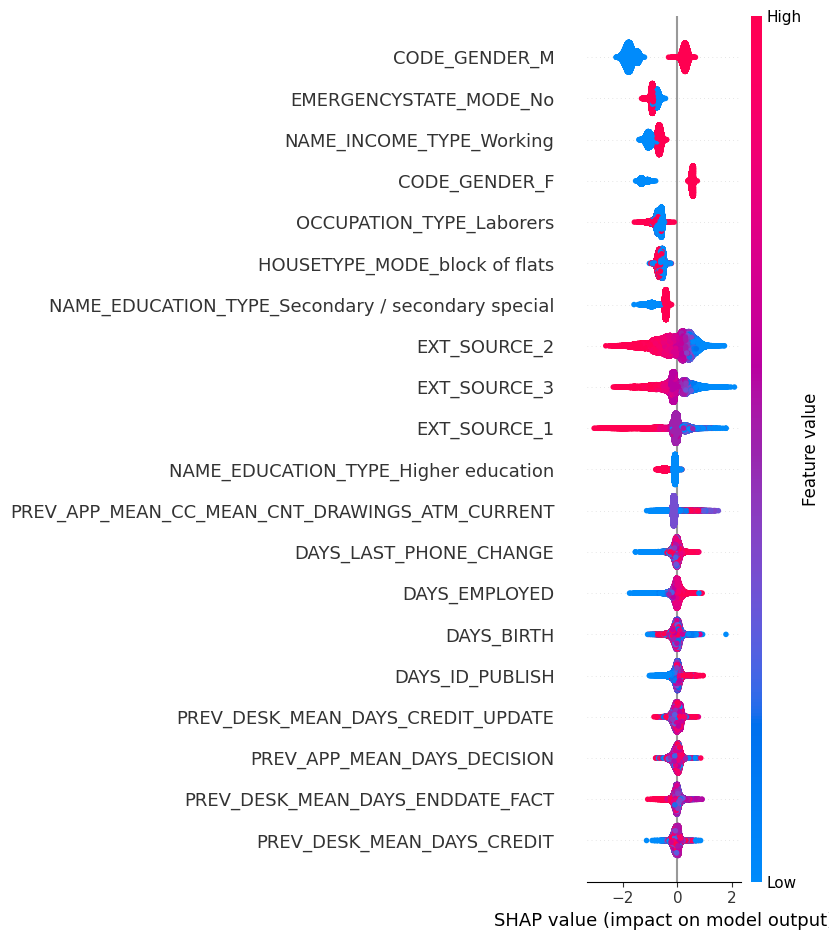

In [ ]:
# Initialisation de l'explainer SHAP avec le modèle retenu
explainer = shap.TreeExplainer(best_lgbm_model)

# Calcul des valeurs SHAP pour l'ensemble des données test
shap_values = explainer.shap_values(X_test)

# Visualisation d'un summary plot pour toutes les instances
shap.summary_plot(shap_values, X_test)

## Shap en vue locale

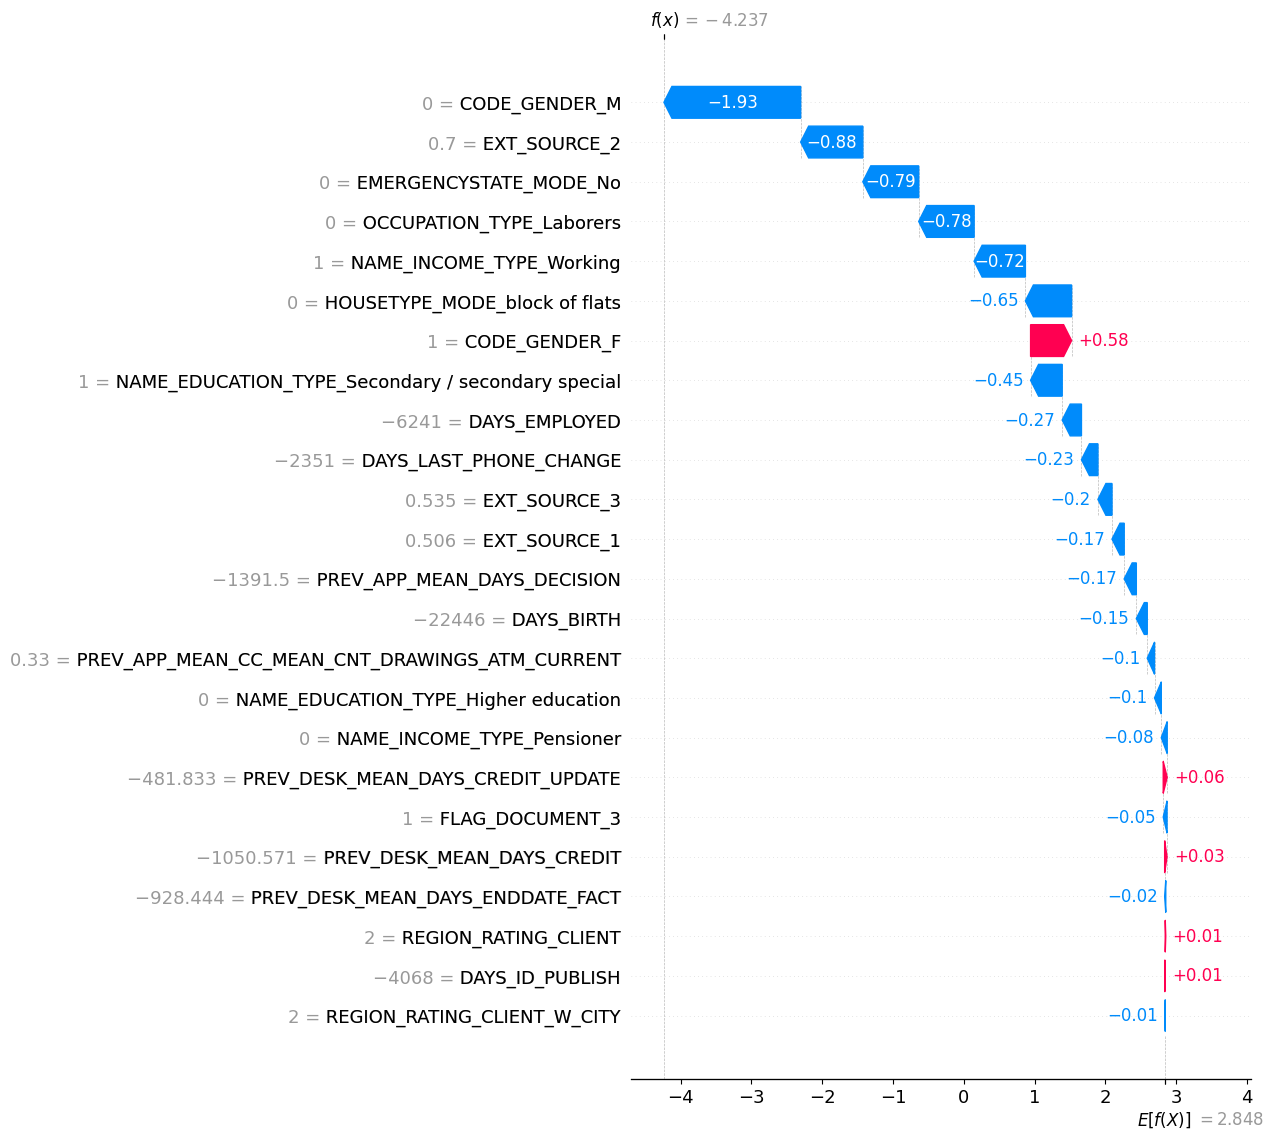

In [ ]:
# Initialisation de l'explaner SHAP avec le modèle retenu
explainer = shap.TreeExplainer(best_lgbm_model)

# Calcul des valeurs
i = 69
X_instance = X_test.iloc[[i]]

shap_values_instance = explainer(X_instance)

# Résumé globale en waterfall
shap.plots.waterfall(shap_values_instance[0], max_display=30)

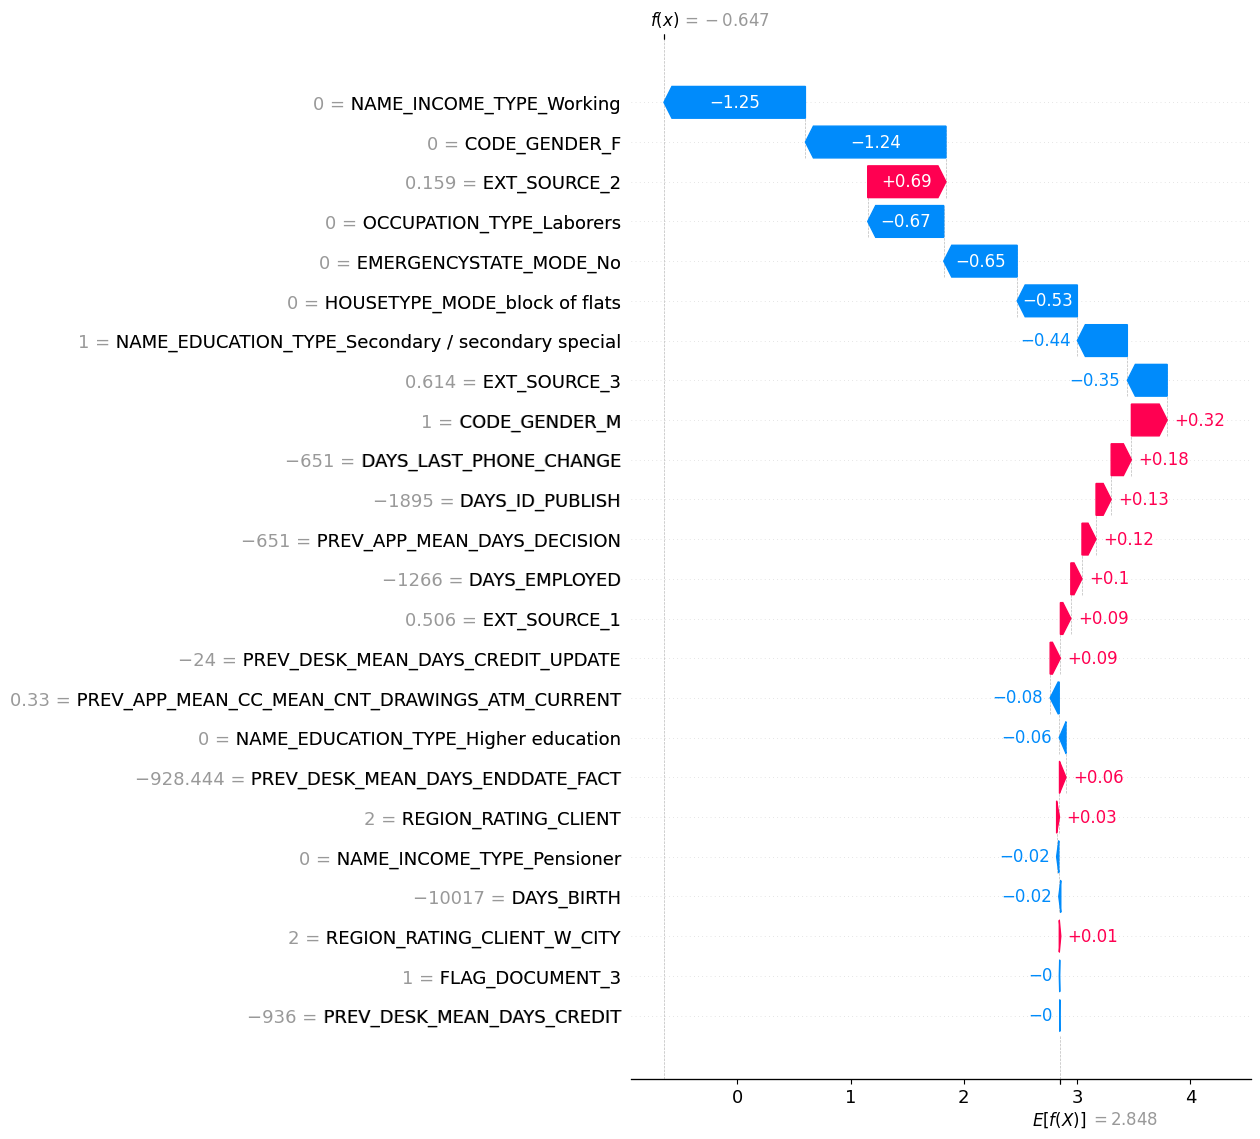

In [ ]:
# Initialisation de l'explaner SHAP avec le modèle retenu
explainer = shap.TreeExplainer(best_lgbm_model)

# Calcul des valeurs
i = 96
X_instance = X_test.iloc[[i]]

shap_values_instance = explainer(X_instance)

# Résumé globale en waterfall
shap.plots.waterfall(shap_values_instance[0], max_display=30)

In [ ]:
# Initialisation de la bibliothèque JavaScript pour les visualisations SHAP
shap.initjs()

# Initialisation de l'explainer SHAP avec le modèle retenu
explainer = shap.TreeExplainer(best_lgbm_model)

# Sélection de la première instance du dataset
X_instance_1 = X_test.iloc[[69]]  # Première instance

# Calcul des valeurs SHAP pour la première instance
shap_values_instance_1 = explainer(X_instance_1)

# Génération du force plot pour la première instance
print("Force plot pour la première instance:")
shap.force_plot(explainer.expected_value, shap_values_instance_1.values, X_instance_1)

Force plot pour la première instance:


In [ ]:
# Initialisation de la bibliothèque JavaScript pour les visualisations SHAP
shap.initjs()

# Initialisation de l'explainer SHAP avec le modèle retenu
explainer = shap.TreeExplainer(best_lgbm_model)

# Sélection de la deuxième instance du dataset
X_instance_2 = X_test.iloc[[96]]  # Deuxième instance

# Calcul des valeurs SHAP pour la deuxième instance
shap_values_instance_2 = explainer(X_instance_2)

# Génération du force plot pour la deuxième instance
print("Force plot pour la deuxième instance:")
shap.force_plot(explainer.expected_value, shap_values_instance_2.values, X_instance_2)

Force plot pour la deuxième instance:


- SHAP (SHapley Additive exPlanations) est une méthode basée sur la théorie des jeux qui attribue à chaque variable une valeur reflétant son impact sur la prédiction.    
___
- Interprétation :
  - Les variables avec une valeur SHAP positive augmentent la probabilité que le client ne rembourse pas le prêt.
  - Les variables avec une valeur SHAP négative augmentent la probabilité que le client rembourse le prêt.    

- Utilisation pratique :
  - Les chargés de relation client peuvent comprendre pourquoi un client a été classé comme risqué en regardant les variables qui ont le plus contribué à cette prédiction.
  - Cela leur permet de discuter avec le client des facteurs spécifiques et potentiellement de proposer des solutions adaptées.